<a href="https://colab.research.google.com/github/somkat16/DS-projects/blob/main/Runner_Prediction_Times.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as data
import tensorflow as tf

In [ ]:
file_path = '/content/Track_Results.xlsx'
df_track = pd.read_excel(file_path, sheet_name='Sheet7')

def conversion_time(time_str):
    try:
        minutes, seconds = map(float, time_str.split(':'))
        return minutes * 60 + seconds
    except:
        return np.nan

df_track['Time_seconds'] = df_track['Time '].astype(str).apply(conversion_time)
df_clean = df_track.dropna(subset=['Time_seconds'])
del df_clean['Date1']


df_clean


,Name,Time (minutes),Event,Time,Date,Time_seconds
0,"Appleton, Margo",00:04:11,ACC Outdoor Track & Field Championships,4:11.00,2025-05-15,251.00
1,"Appleton, Margo",00:04:05.680000,Raleigh Relays,4:05.68,2025-03-27,245.68
2,"Appleton, Margo",00:04:11.040000,ACC Outdoor Track & Field Championships,4:11.04,2024-05-10,251.04
3,"Appleton, Margo",00:04:11.410000,2024 Bryan Clay Invitational,4:11.41,2024-04-11,251.41
4,"Appleton, Margo",00:04:09.830000,NCAA Division I Outdoor Track & Field Champion...,4:09.83,2023-06-07,249.83
...,...,...,...,...,...,...
262,"Robertson, Kaiya",00:04:14.410000,2025 Bryan Clay Invitational,4:14.41,2025-04-16,254.41
263,"Robertson, Kaiya",00:04:23.730000,NCAA West Preliminary Round,4:23.73,2023-05-24,263.73
264,"Robertson, Kaiya",00:04:18.920000,Mountain West Outdoor Track & Field Championships,4:18.92,2023-05-11,258.92
265,"Robertson, Kaiya",00:04:18.680000,2023 Bryan Clay Invitational,4:18.68,2023-04-13,258.68


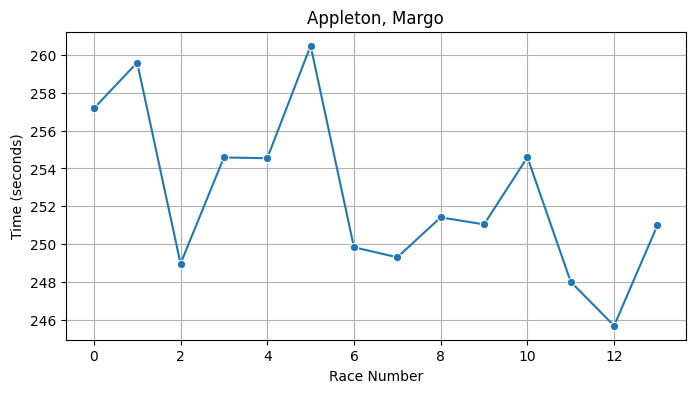

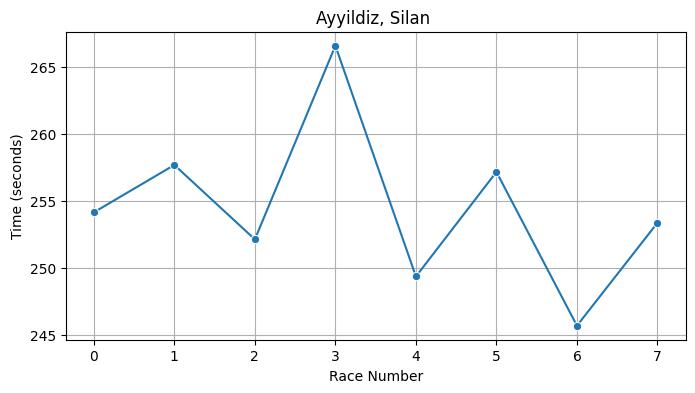

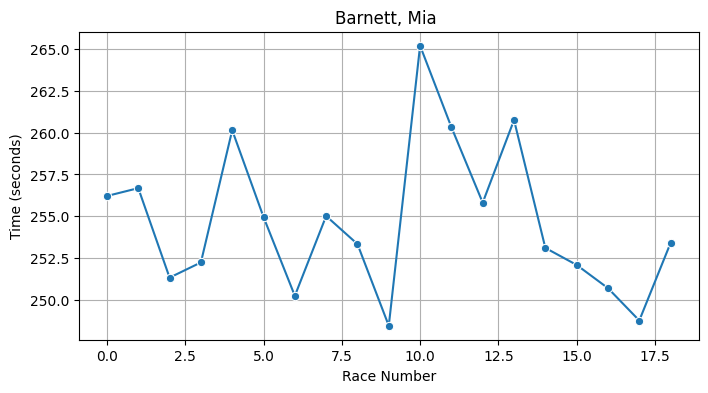

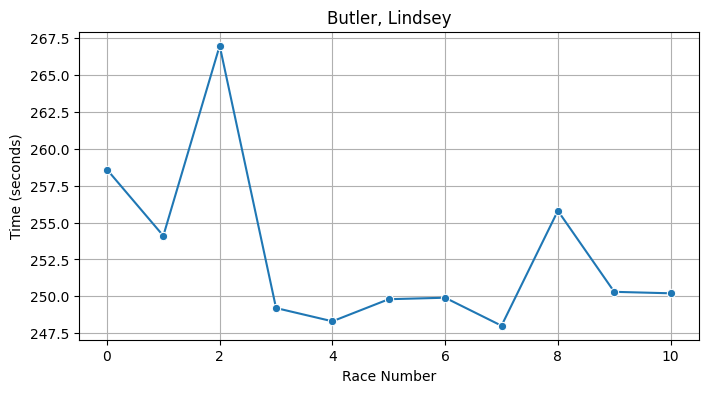

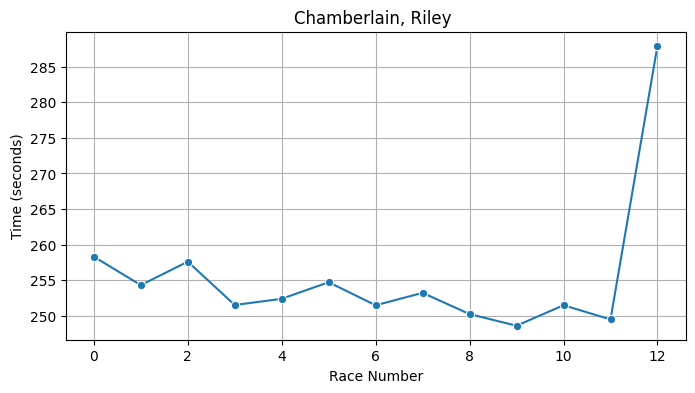

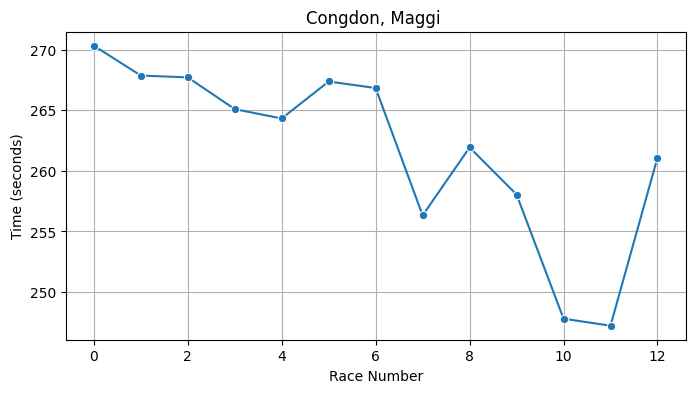

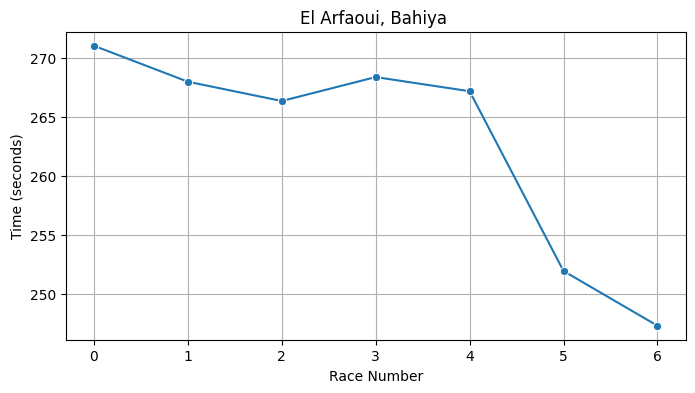

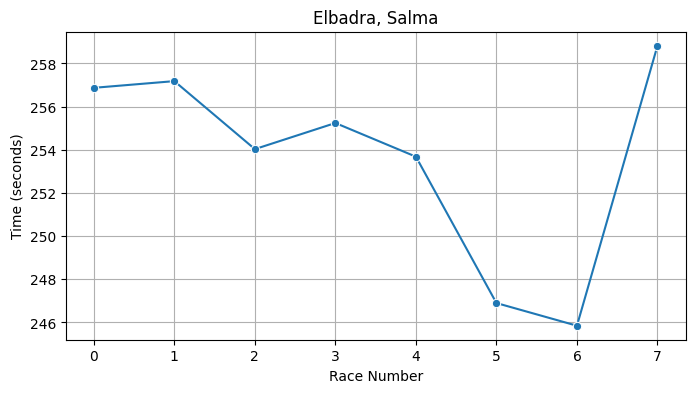

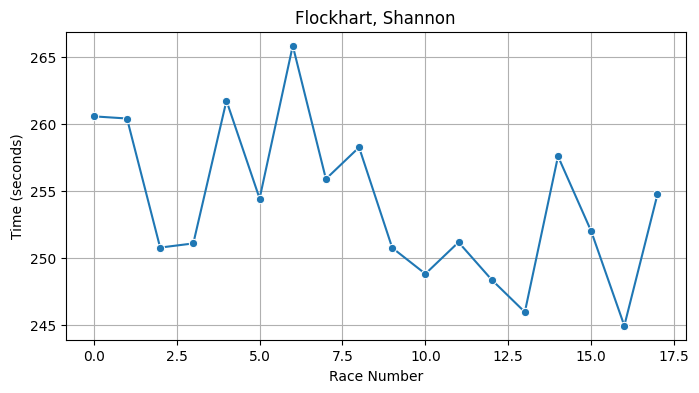

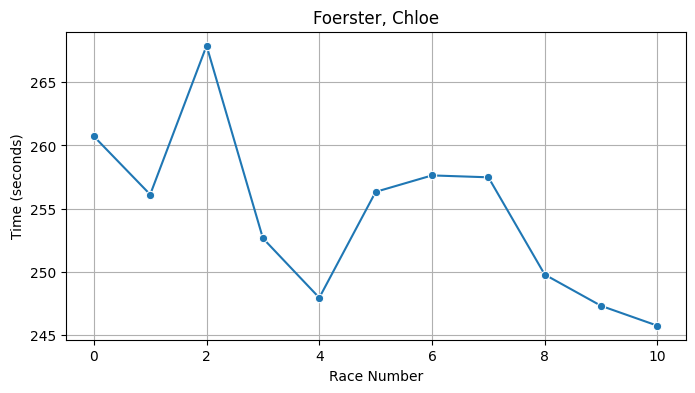

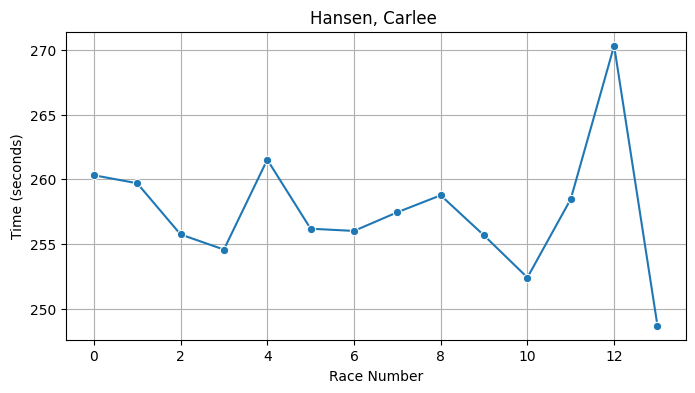

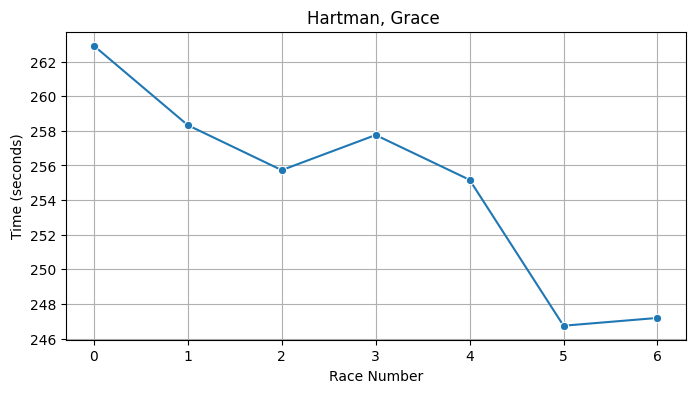

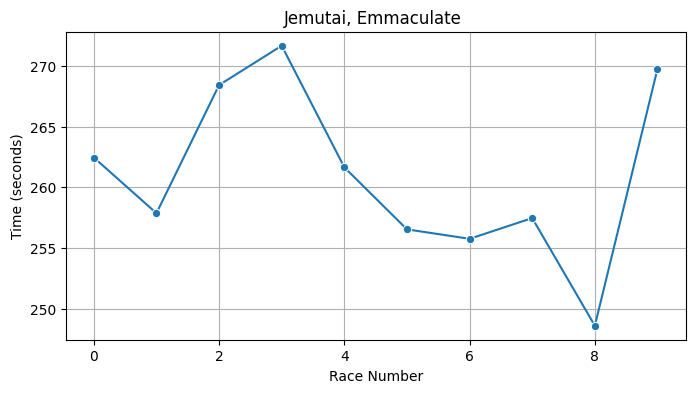

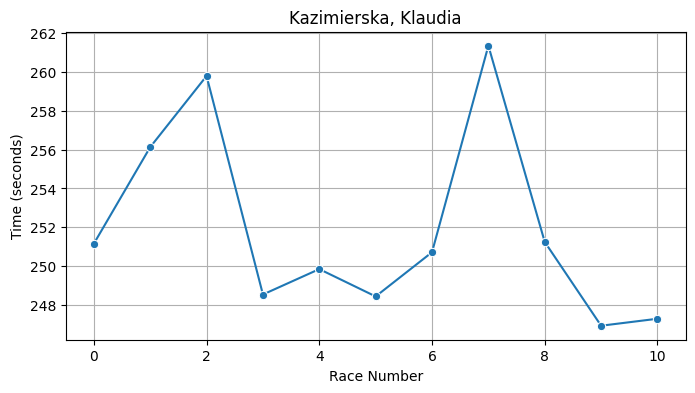

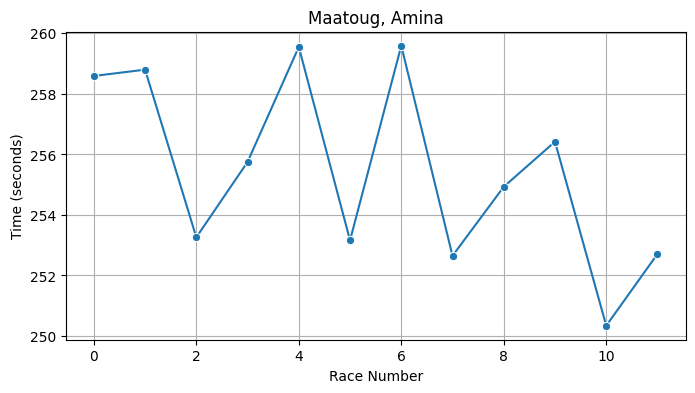

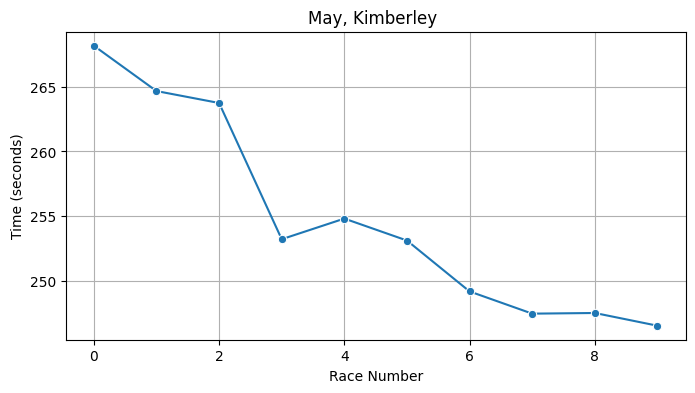

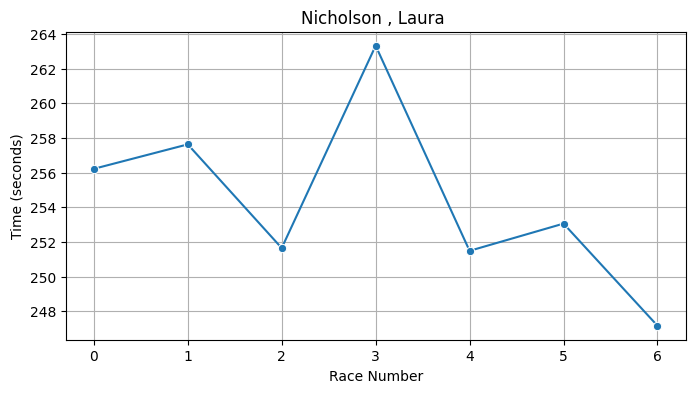

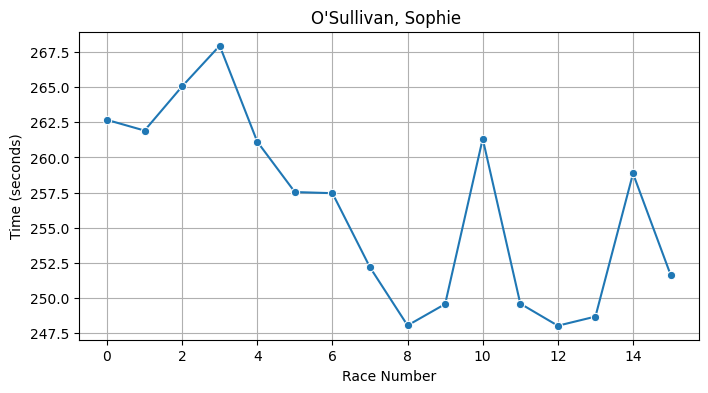

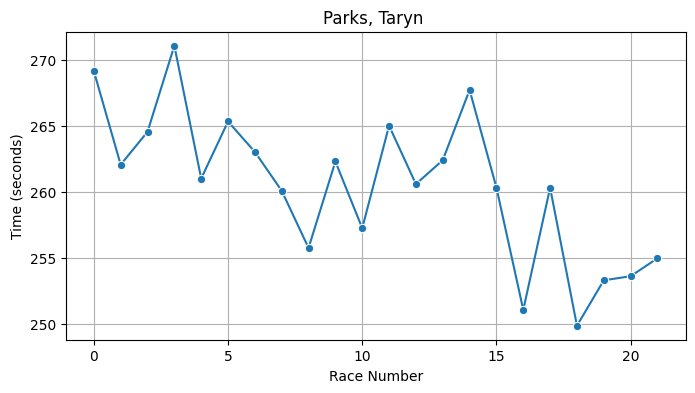

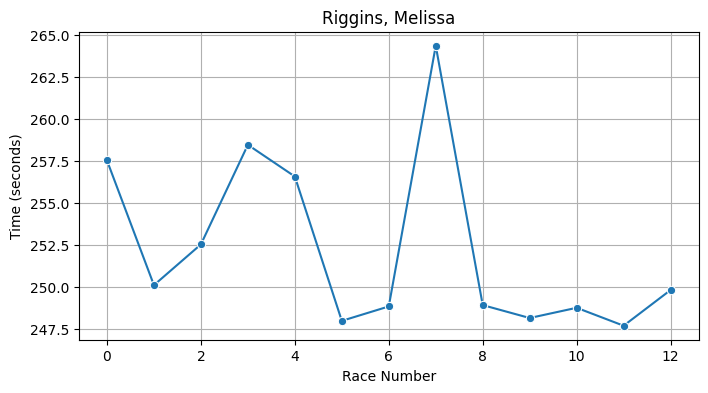

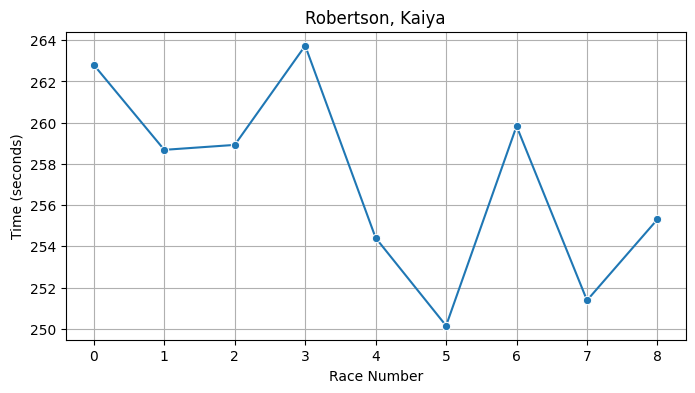

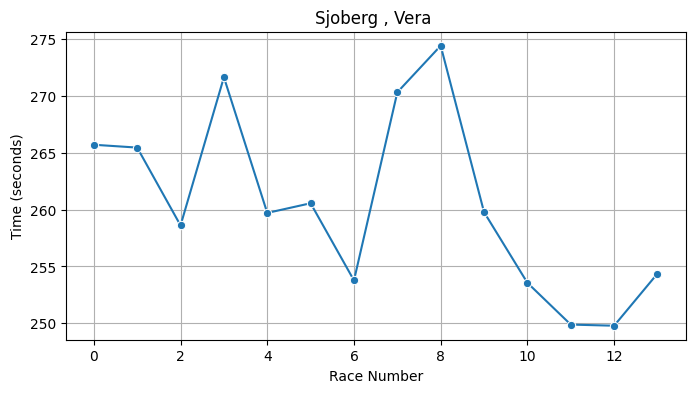

In [ ]:
import seaborn as sns

# Rename column
df_clean = df_clean.rename(columns={'Name ': 'Runner'})

# Create Race_Number column
df_clean = df_clean.sort_values(by=['Runner', 'Date'])
df_clean['Race_Number'] = df_clean.groupby('Runner').cumcount()

unique_runners = df_clean['Runner'].unique()

for runner in unique_runners:
    runner_data = df_clean[df_clean['Runner'] == runner]
    plt.figure(figsize=(8, 4))
    sns.lineplot(data=runner_data, x='Race_Number', y='Time_seconds', marker='o')
    plt.title(f"{runner}")
    plt.xlabel("Race Number")
    plt.ylabel("Time (seconds)")
    plt.grid(True)
    plt.show()

In [ ]:
fastest_times = (
    df_clean.groupby('Runner')
    .agg({'Time_seconds': 'min'})
    .reset_index()
)

# Sorting from fastest to slowest
fastest_times_sorted = (
    fastest_times.sort_values(by='Time_seconds', ascending=True)
    .reset_index(drop=True)
)

# Convert seconds to MM:SS.00 format
fastest_times_sorted['Fastest_Time'] = fastest_times_sorted['Time_seconds'].apply(
    lambda x: f"{int(x//60)}:{x%60:05.2f}"
)

# Display
fastest_times_sorted

,Runner,Time_seconds,Fastest_Time
0,"Flockhart, Shannon",244.97,4:04.97
1,"Ayyildiz, Silan",245.66,4:05.66
2,"Appleton, Margo",245.68,4:05.68
3,"Foerster, Chloe",245.75,4:05.75
4,"Elbadra, Salma",245.85,4:05.85
5,"May, Kimberley",246.58,4:06.58
6,"Hartman, Grace",246.74,4:06.74
7,"Kazimierska, Klaudia",246.92,4:06.92
8,"Nicholson , Laura",247.17,4:07.17
9,"Congdon, Maggi",247.23,4:07.23


In [ ]:
df_clean.columns


Index(['Runner', 'Time (minutes)', 'Event', 'Time ', 'Date', 'Time_seconds',
       'Race_Number'],
      dtype='object')

In [ ]:
# Step 1: Sort for time-based feature creation
df_clean = df_clean.sort_values(['Runner', 'Date'])

# Step 2: Core feature engineering
df_clean['days_since'] = df_clean.groupby('Runner')['Date'].diff().dt.days
df_clean['Avg_Pace_400m'] = df_clean['Time_seconds'] / (1500 / 400)

# Rolling average of past 3 races (shifted to avoid leakage)
df_clean['Rolling_Avg_3'] = (
    df_clean.groupby('Runner')['Time_seconds']
    .rolling(window=3, min_periods=1)
    .mean()
    .shift(1)
    .reset_index(level=0, drop=True)
)

# Rolling standard deviation of past 3 races
df_clean['Rolling_Std_3'] = (
    df_clean.groupby('Runner')['Time_seconds']
    .rolling(window=3, min_periods=1)
    .std()
    .shift(1)
    .reset_index(level=0, drop=True)
)

# Z-score normalization of Time_seconds within each runner
df_clean['Z_Time'] = df_clean.groupby('Runner')['Time_seconds'].transform(
    lambda x: (x - x.mean()) / x.std()
)

# Step 3: Compute and merge PR (personal record)
fastest_times = (
    df_clean.groupby('Runner')
    .agg({'Time_seconds': 'min'})
    .reset_index()
    .rename(columns={'Time_seconds': 'PR_Time'})
)
df_clean = df_clean.merge(fastest_times, on='Runner', how='left')

# Step 4: Time difference from PR
df_clean['Time_from_PR'] = df_clean['Time_seconds'] - df_clean['PR_Time']

# Step 5: Previous time and delta
df_clean['Previous_Time'] = df_clean.groupby('Runner')['Time_seconds'].shift(1)
df_clean['Time_Change'] = df_clean['Time_seconds'] - df_clean['Previous_Time']

# Step 6: Lag features
for lag in range(1, 6):
    df_clean[f'lag_{lag}'] = df_clean.groupby('Runner')['Time_seconds'].shift(lag)

# Step 7: Drop rows with missing values in any required columns
required_features = [
    'days_since', 'Avg_Pace_400m', 'Rolling_Avg_3', 'Rolling_Std_3',
    'Time_from_PR', 'Previous_Time', 'Z_Time'
] + [f'lag_{i}' for i in range(1, 6)]

model_lm = df_clean.dropna(subset=required_features).copy()

# Step 8: Drop Previous_Time now that Time_Change is calculated
model_lm = model_lm.drop(columns=['Previous_Time'])
model_lm

,Runner,Time (minutes),Event,Time,Date,Time_seconds,Race_Number,days_since,Avg_Pace_400m,Rolling_Avg_3,Rolling_Std_3,Z_Time,PR_Time,Time_from_PR,Time_Change,lag_1,lag_2,lag_3,lag_4,lag_5
5,"Appleton, Margo",00:04:20.490000,ACC Outdoor Track & Field Championships,4:20.49,2023-05-25,260.49,5,0.0,69.464000,252.693333,3.233223,1.798856,245.68,14.81,5.95,254.54,254.58,248.96,259.60,257.17
6,"Appleton, Margo",00:04:09.830000,NCAA Division I Outdoor Track & Field Champion...,4:09.83,2023-06-07,249.83,6,13.0,66.621333,256.536667,3.423746,-0.626926,245.68,4.15,-10.66,260.49,254.54,254.58,248.96,259.60
7,"Appleton, Margo",00:04:09.300000,NCAA Division I Outdoor Track & Field Champion...,4:09.30,2023-06-08,249.30,7,1.0,66.480000,254.953333,5.342006,-0.747532,245.68,3.62,-0.53,249.83,260.49,254.54,254.58,248.96
8,"Appleton, Margo",00:04:11.410000,2024 Bryan Clay Invitational,4:11.41,2024-04-11,251.41,8,308.0,67.042667,253.206667,6.313116,-0.267382,245.68,5.73,2.11,249.30,249.83,260.49,254.54,254.58
9,"Appleton, Margo",00:04:11.040000,ACC Outdoor Track & Field Championships,4:11.04,2024-05-10,251.04,9,29.0,66.944000,250.180000,1.097679,-0.351579,245.68,5.36,-0.37,251.41,249.30,249.83,260.49,254.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,"Sjoberg , Vera",00:04:19.770000,NCAA East First Round,4:19.77,2024-05-22,259.77,9,9.0,69.272000,266.153333,10.917520,-0.095463,249.79,9.98,-14.62,274.39,270.30,253.77,260.55,259.70
263,"Sjoberg , Vera",00:04:13.560000,Bruce Lehane Scarlet and White Invitational,4:13.56,2025-02-08,253.56,10,262.0,67.616000,268.153333,7.542694,-0.874034,249.79,3.77,-6.21,259.77,274.39,270.30,253.77,260.55
264,"Sjoberg , Vera",00:04:09.890000,Boston University David Hemery Valentine Invit...,4:09.89,2025-02-14,249.89,11,6.0,66.637333,262.573333,10.694215,-1.334155,249.79,0.10,-3.67,253.56,259.77,274.39,270.30,253.77
265,"Sjoberg , Vera",00:04:09.790000,Wake Forest Invitational 2025,4:09.79,2025-04-17,249.79,12,62.0,66.610667,254.406667,4.994120,-1.346693,249.79,0.00,-0.10,249.89,253.56,259.77,274.39,270.30


In [ ]:
model_lm.columns

Index(['Runner', 'Time (minutes)', 'Event', 'Time ', 'Date', 'Time_seconds',
       'Race_Number', 'days_since', 'Avg_Pace_400m', 'Rolling_Avg_3',
       'Rolling_Std_3', 'Z_Time', 'PR_Time', 'Time_from_PR', 'Time_Change',
       'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5'],
      dtype='object')

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_absolute_error, r2_score

# # STEP 1: Load & clean data
# df = pd.read_excel('/content/Track_Results.xlsx', sheet_name='Sheet7')

# # Parse time
# def conversion_time(time_str):
#     try:
#         minutes, seconds = map(float, time_str.split(':'))
#         return minutes * 60 + seconds
#     except:
#         return np.nan

# df['Time_seconds'] = df['Time '].astype(str).apply(conversion_time)
# df = df.rename(columns={'Name ': 'Runner'})
# df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
# df = df.dropna(subset=['Time_seconds', 'Date'])

# # Keep only the fastest time per runner per date
# df = df.sort_values(['Runner', 'Date', 'Time_seconds'])
# df = df.groupby(['Runner', 'Date'], as_index=False).first()

# # Filter runners with enough data
# runner_counts = df['Runner'].value_counts()
# df = df[df['Runner'].isin(runner_counts[runner_counts >= 6].index)]

# # STEP 2: Create lag features (e.g., previous 5 race times)
# def build_lag_features(df, lags=5):
#     df = df.sort_values(['Runner', 'Date'])
#     for lag in range(1, lags + 1):
#         df[f'lag_{lag}'] = df.groupby('Runner')['Time_seconds'].shift(lag)
#     return df

# df_lagged = build_lag_features(df, lags=5)
# df_lagged = df_lagged.dropna(subset=[f'lag_{i}' for i in range(1, 6)])

# # STEP 3: Time-based train/test split per runner
# train_list, test_list = [], []

# for runner, group in df_lagged.groupby('Runner'):
#     group = group.sort_values('Date')
#     cutoff = int(len(group) * 0.8)
#     train_list.append(group.iloc[:cutoff])
#     test_list.append(group.iloc[cutoff:])

# train_df = pd.concat(train_list).reset_index(drop=True)
# test_df = pd.concat(test_list).reset_index(drop=True)

# # STEP 4: Train model
# features = [f'lag_{i}' for i in range(1, 6)]
# X_train = train_df[features]
# y_train = train_df['Time_seconds']
# X_test = test_df[features]
# y_test = test_df['Time_seconds']

# model = RandomForestRegressor(n_estimators=100, random_state=42)
# model.fit(X_train, y_train)

# y_pred = model.predict(X_test)

# # STEP 5: Evaluate
# mae = mean_absolute_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
# print(f"Random Forest MAE: {mae:.2f} seconds")
# print(f"Random Forest R²: {r2:.3f}")

# # STEP 6: Compare with baseline (last race time)
# baseline = X_test['lag_1']
# baseline_mae = mean_absolute_error(y_test, baseline)
# print(f"Baseline MAE (last race time): {baseline_mae:.2f} seconds")

Random Forest MAE: 0.39 seconds
Random Forest R²: 0.985


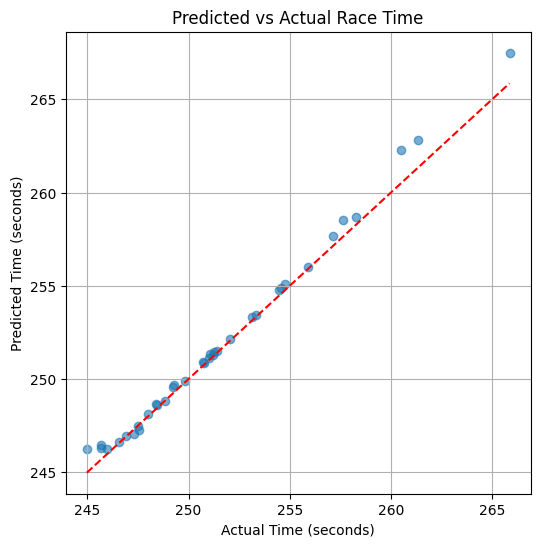

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# === Step 0: Load and prepare data ===
# Ensure your df_clean has at least these columns:
# ['Runner', 'Date', 'Time_seconds']

# Step 1: Sort by runner and race date
df_clean = df_clean.sort_values(['Runner', 'Date'])

# Step 2: Feature engineering (past-only)
df_clean['days_since'] = df_clean.groupby('Runner')['Date'].diff().dt.days
df_clean['Avg_Pace_400m'] = df_clean['Time_seconds'] / (1500 / 400)

df_clean['Rolling_Avg_3'] = (
    df_clean.groupby('Runner')['Time_seconds']
    .rolling(window=3, min_periods=1).mean()
    .shift(1).reset_index(level=0, drop=True)
)

df_clean['Rolling_Std_3'] = (
    df_clean.groupby('Runner')['Time_seconds']
    .rolling(window=3, min_periods=1).std()
    .shift(1).reset_index(level=0, drop=True)
)

for lag in range(1, 6):
    df_clean[f'lag_{lag}'] = df_clean.groupby('Runner')['Time_seconds'].shift(lag)

fastest_times = df_clean.groupby('Runner')['Time_seconds'].min().reset_index()
fastest_times = fastest_times.rename(columns={'Time_seconds': 'PR_Time'})
df_clean = df_clean.merge(fastest_times, on='Runner', how='left')

df_clean['Time_from_PR'] = df_clean['Time_seconds'] - df_clean['PR_Time']
df_clean['Z_Time'] = (df_clean['Time_seconds'] - df_clean['Rolling_Avg_3']) / df_clean['Rolling_Std_3']

# Step 3: Drop rows with any missing values in features or target
features = [
    'days_since', 'Rolling_Avg_3', 'Rolling_Std_3',
    'Time_from_PR', 'Avg_Pace_400m', 'Z_Time',
    'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5'
]
target = 'Time_seconds'

model_lm = df_clean.dropna(subset=features + [target]).copy()

# Step 4: Group-aware train/test split (no runner leakage)
groups = model_lm['Runner']
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(model_lm, groups=groups))

X_train = model_lm.iloc[train_idx][features]
y_train = model_lm.iloc[train_idx][target]
X_test = model_lm.iloc[test_idx][features]
y_test = model_lm.iloc[test_idx][target]

# Step 5: Train and evaluate Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Random Forest MAE: {mae:.2f} seconds")
print(f"Random Forest R²: {r2:.3f}")

# Optional: Visualize predictions
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Time (seconds)")
plt.ylabel("Predicted Time (seconds)")
plt.title("Predicted vs Actual Race Time")
plt.grid(True)
plt.show()



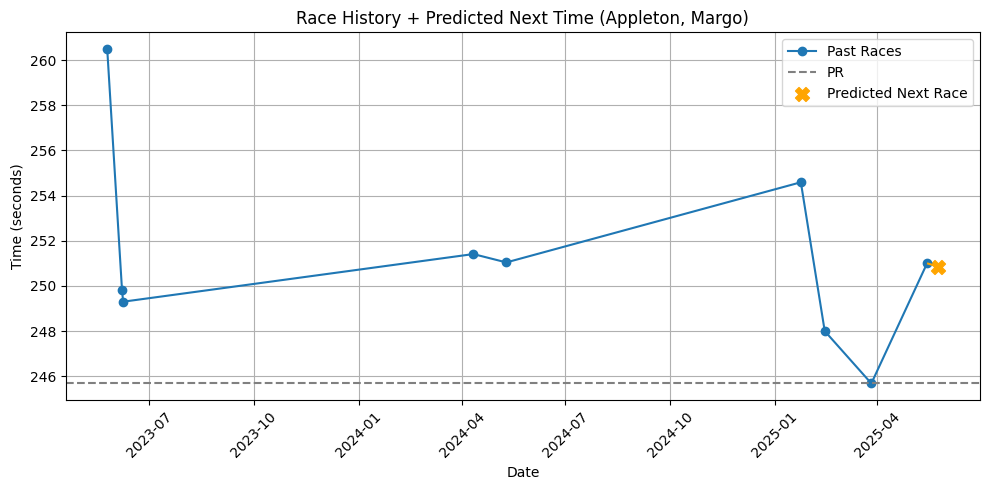

 Predicted Next Race Time for Appleton, Margo: 4:10.85


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from datetime import timedelta

# === Step 0: Filter for one runner ===
runner_name = "Appleton, Margo"
df_runner = df_clean[df_clean['Runner'] == runner_name].copy()
df_runner = df_runner.sort_values('Date')

# === Step 1: Feature Engineering ===
df_runner['days_since'] = df_runner['Date'].diff().dt.days
df_runner['Avg_Pace_400m'] = df_runner['Time_seconds'] / (1500 / 400)

df_runner['Rolling_Avg_3'] = df_runner['Time_seconds'].rolling(3, min_periods=1).mean().shift(1)
df_runner['Rolling_Std_3'] = df_runner['Time_seconds'].rolling(3, min_periods=1).std().shift(1)

for lag in range(1, 6):
    df_runner[f'lag_{lag}'] = df_runner['Time_seconds'].shift(lag)

df_runner['PR_Time'] = df_runner['Time_seconds'].cummin().shift(1)
df_runner['Time_from_PR'] = df_runner['Time_seconds'] - df_runner['PR_Time']
df_runner['Z_Time'] = (df_runner['Time_seconds'] - df_runner['Rolling_Avg_3']) / df_runner['Rolling_Std_3']

# === Step 2: Drop rows with missing values ===
features = [
    'days_since', 'Rolling_Avg_3', 'Rolling_Std_3',
    'Time_from_PR', 'Avg_Pace_400m', 'Z_Time',
    'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5'
]
target = 'Time_seconds'
df_runner = df_runner.dropna(subset=features + [target])

# === Step 3: Train model ===
X_train = df_runner[features]
y_train = df_runner[target]

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# === Step 4: Predict next race ===
days_until_next_race = 10  # <- Change this as needed

latest = df_runner.iloc[-1]

X_next = pd.DataFrame([{
    'days_since': days_until_next_race,
    'Rolling_Avg_3': latest['Rolling_Avg_3'],
    'Rolling_Std_3': latest['Rolling_Std_3'],
    'Time_from_PR': latest['Time_from_PR'],
    'Avg_Pace_400m': latest['Avg_Pace_400m'],
    'Z_Time': latest['Z_Time'],
    'lag_1': latest['lag_1'],
    'lag_2': latest['lag_2'],
    'lag_3': latest['lag_3'],
    'lag_4': latest['lag_4'],
    'lag_5': latest['lag_5'],
}])

predicted_time = rf.predict(X_next)[0]
future_date = df_runner['Date'].max() + timedelta(days=days_until_next_race)

# === Step 5: Plot history + prediction ===
plt.figure(figsize=(10, 5))
plt.plot(df_runner['Date'], df_runner['Time_seconds'], marker='o', label='Past Races')
plt.axhline(df_runner['PR_Time'].min(), color='gray', linestyle='--', label='PR')

# Plot predicted time
plt.scatter(future_date, predicted_time, color='orange', marker='X', s=100, label='Predicted Next Race')
plt.plot([df_runner['Date'].iloc[-1], future_date],
         [df_runner['Time_seconds'].iloc[-1], predicted_time],
         color='orange', linestyle='--')

# Formatting
plt.title(f"Race History + Predicted Next Time ({runner_name})")
plt.xlabel("Date")
plt.ylabel("Time (seconds)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Optional: Print prediction
mins, secs = divmod(predicted_time, 60)
print(f" Predicted Next Race Time for {runner_name}: {int(mins)}:{secs:05.2f}")


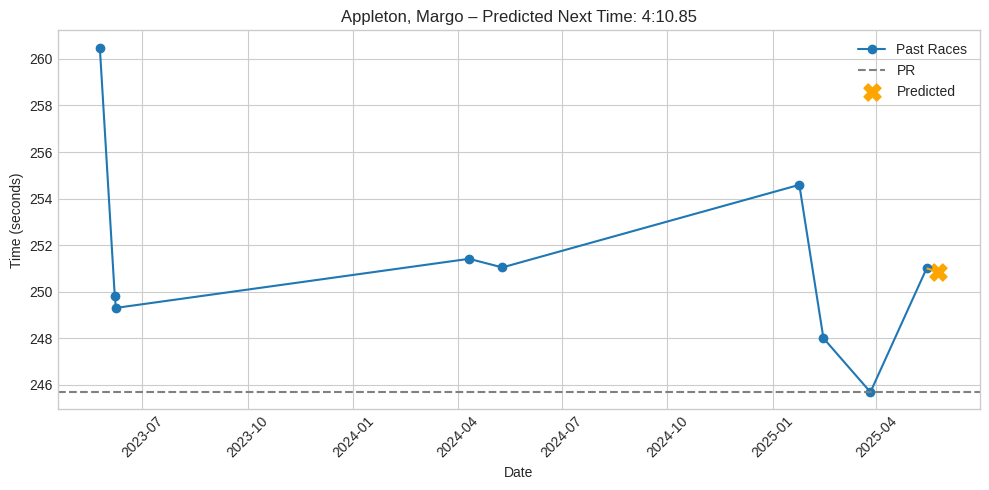

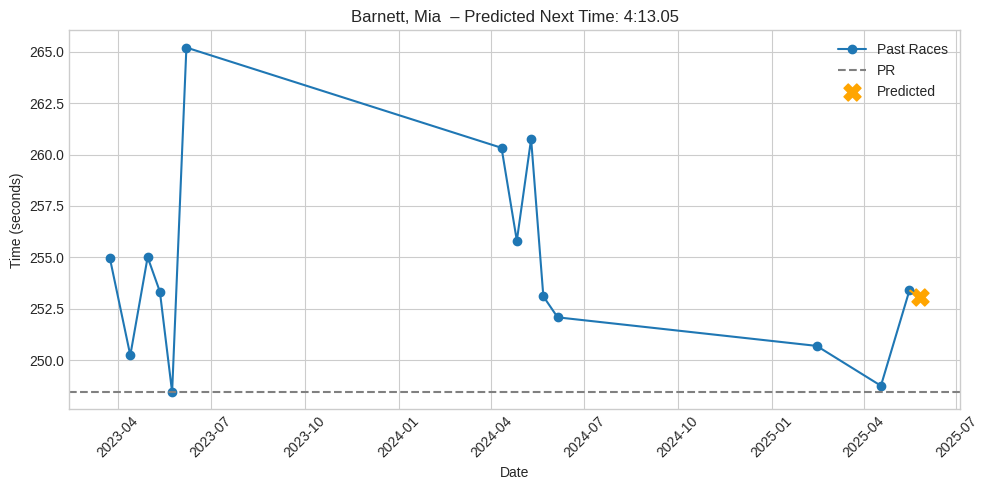

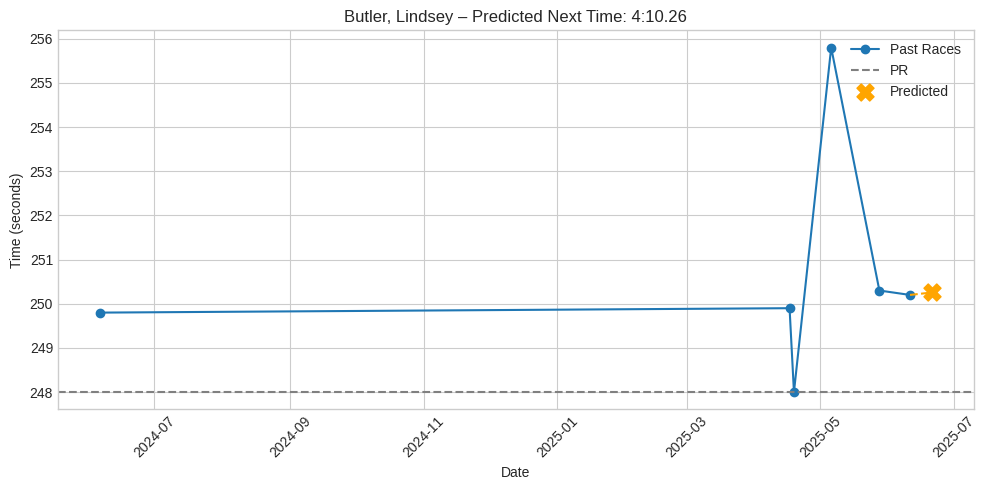

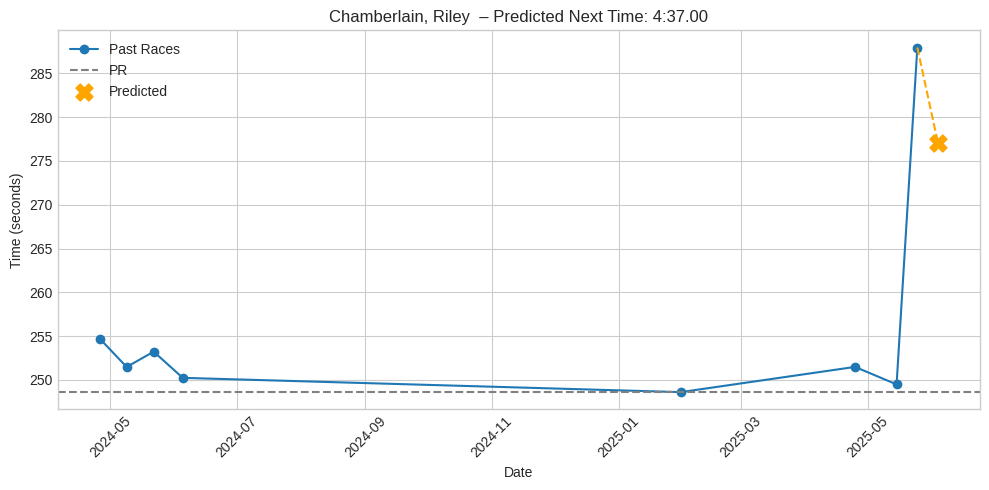

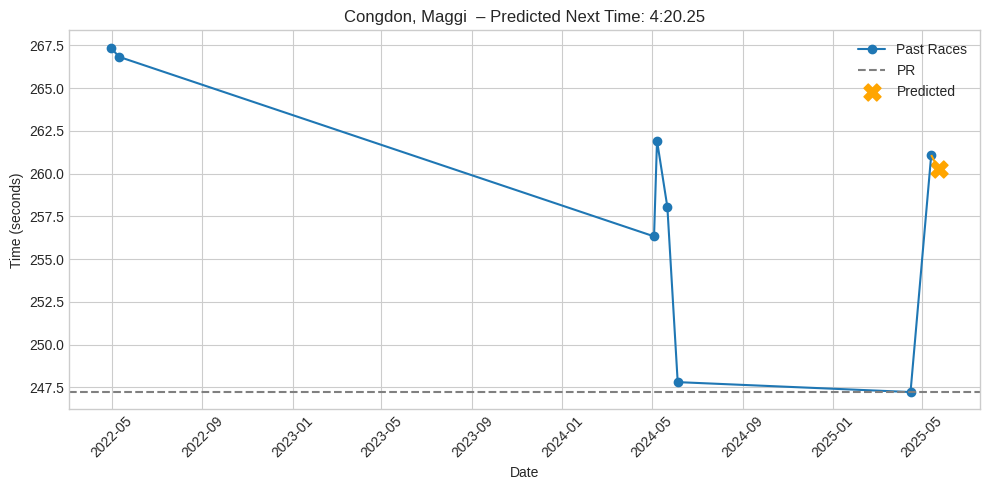

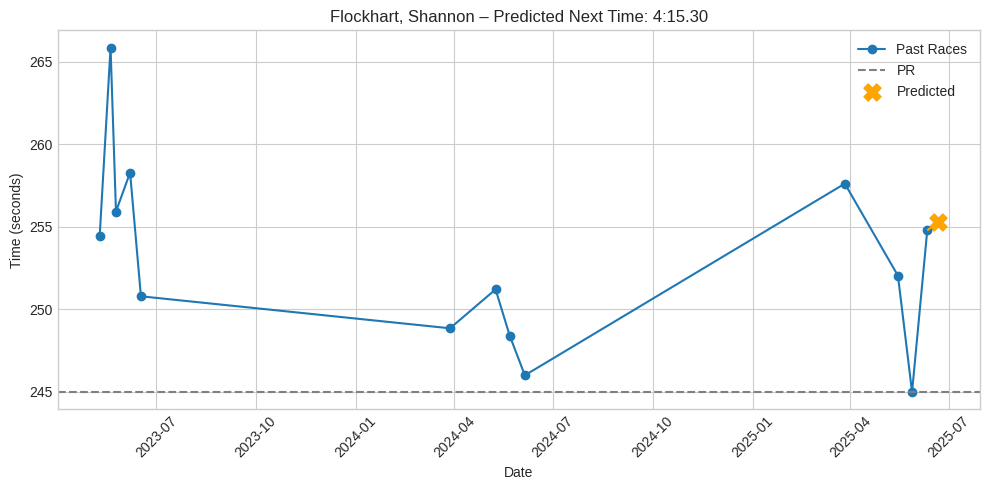

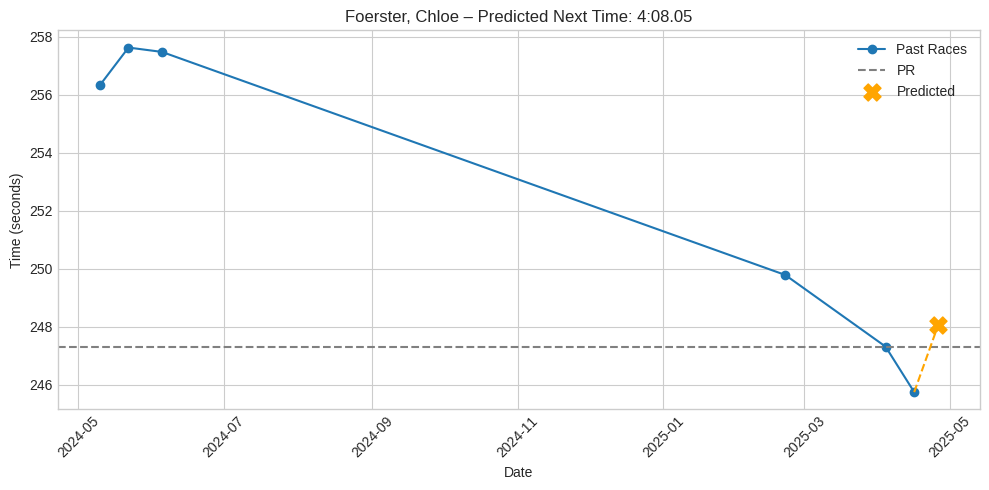

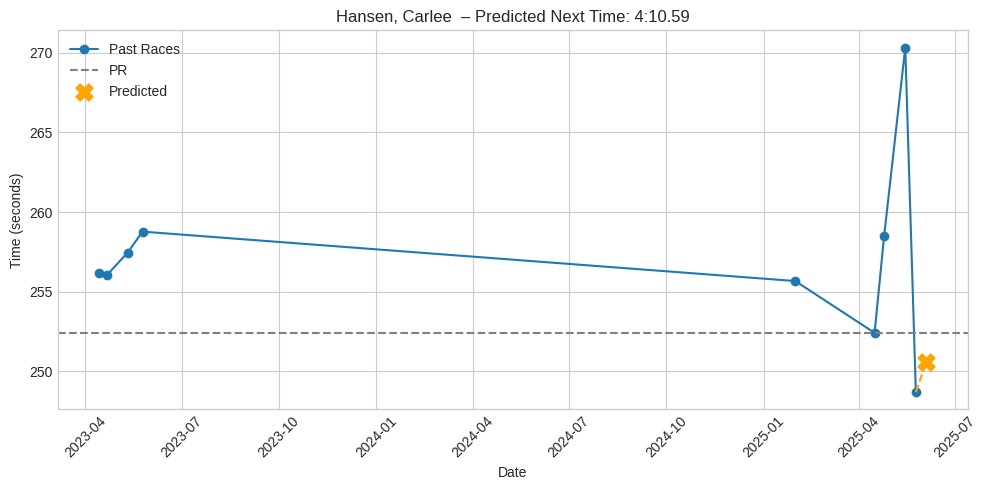

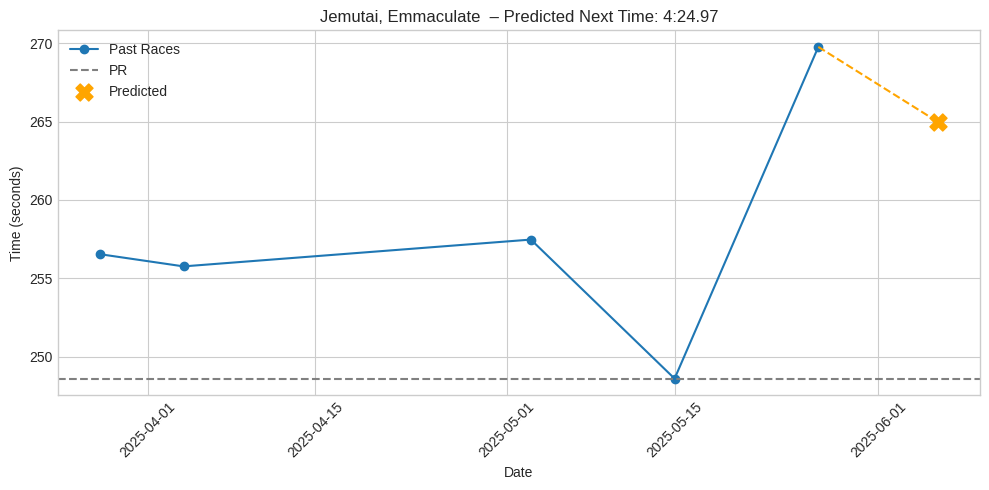

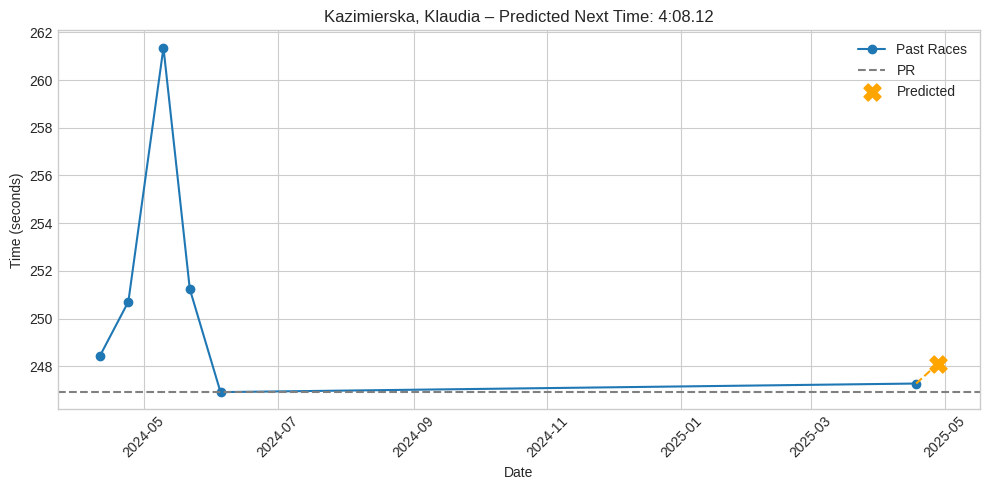

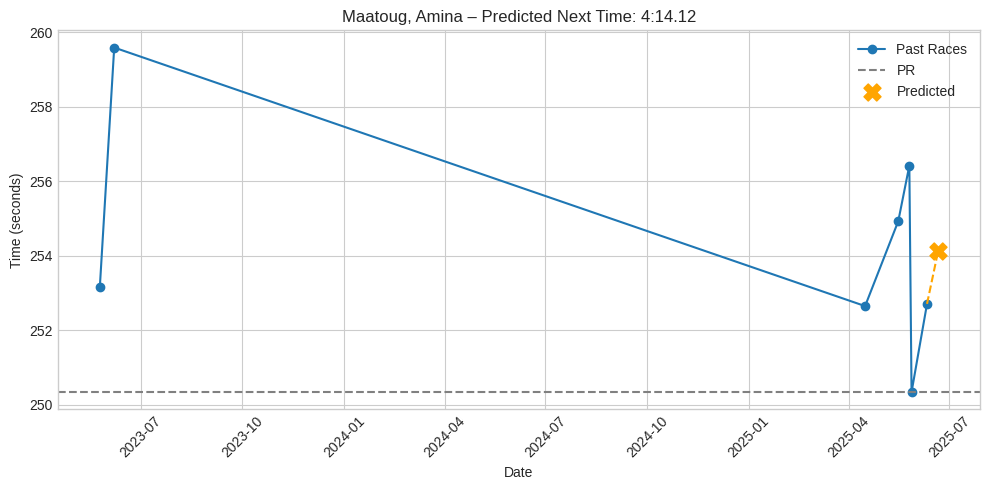

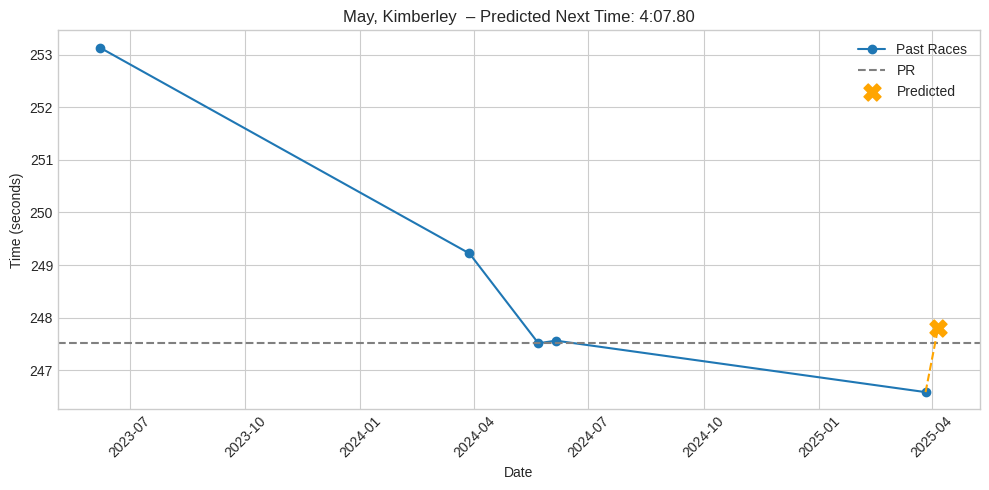

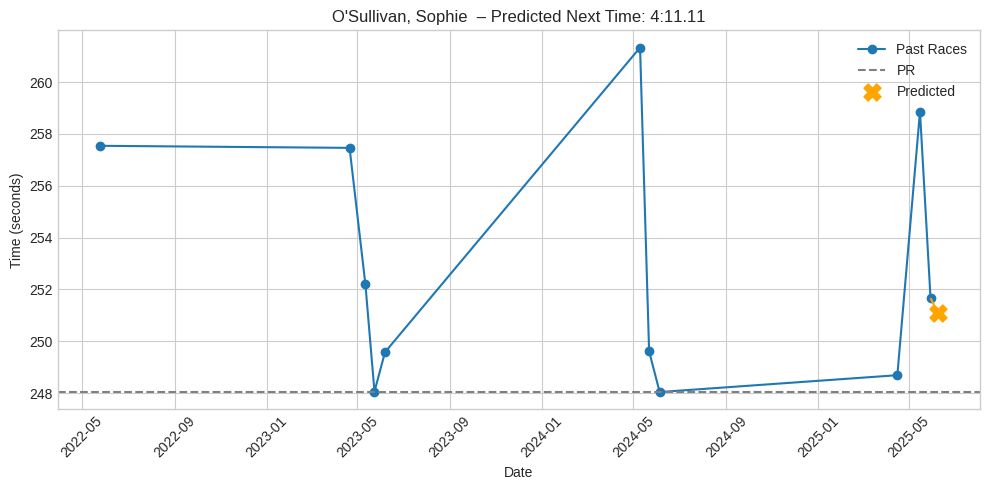

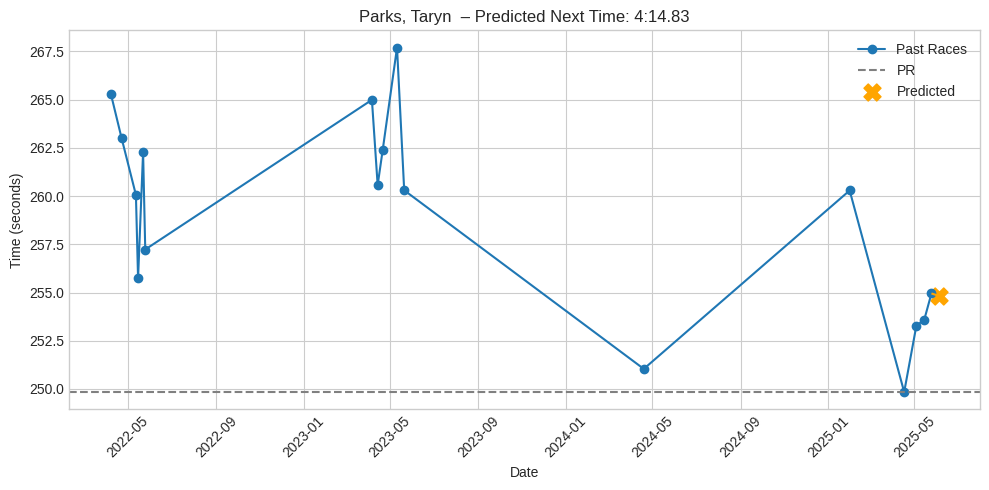

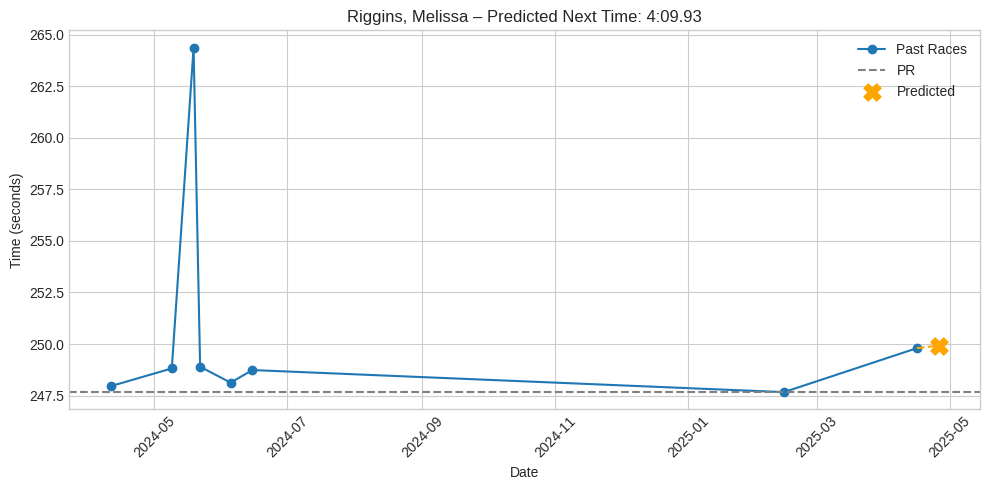

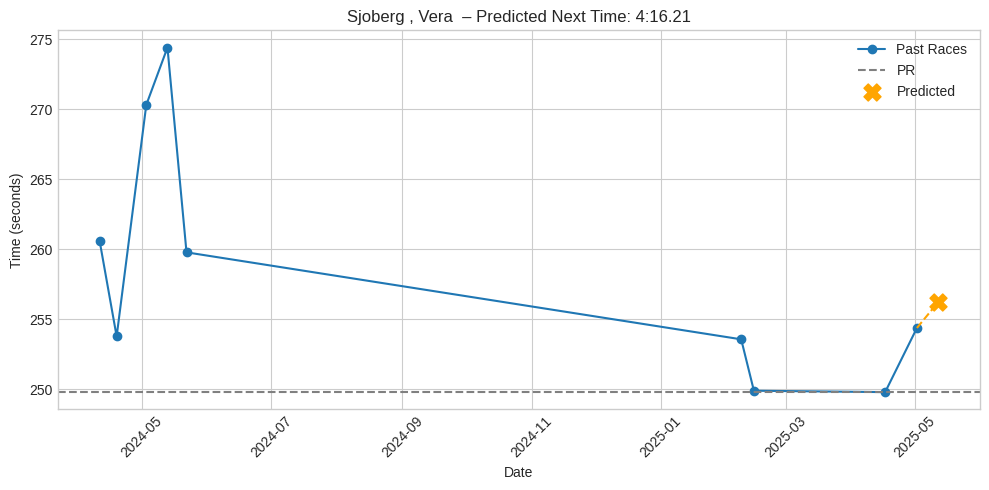

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from datetime import timedelta

# Set days into the future to predict
days_until_next_race = 10

# Save results
all_predictions = []

# Plotting config
plt.style.use('seaborn-v0_8-whitegrid')

for runner_name, df_runner in df_clean.groupby('Runner'):
    df_runner = df_runner.sort_values('Date').copy()

    # Feature Engineering
    df_runner['days_since'] = df_runner['Date'].diff().dt.days
    df_runner['Avg_Pace_400m'] = df_runner['Time_seconds'] / (1500 / 400)
    df_runner['Rolling_Avg_3'] = df_runner['Time_seconds'].rolling(3, min_periods=1).mean().shift(1)
    df_runner['Rolling_Std_3'] = df_runner['Time_seconds'].rolling(3, min_periods=1).std().shift(1)

    for lag in range(1, 6):
        df_runner[f'lag_{lag}'] = df_runner['Time_seconds'].shift(lag)

    df_runner['PR_Time'] = df_runner['Time_seconds'].cummin().shift(1)
    df_runner['Time_from_PR'] = df_runner['Time_seconds'] - df_runner['PR_Time']
    df_runner['Z_Time'] = (df_runner['Time_seconds'] - df_runner['Rolling_Avg_3']) / df_runner['Rolling_Std_3']

    # Drop missing
    features = [
        'days_since', 'Rolling_Avg_3', 'Rolling_Std_3',
        'Time_from_PR', 'Avg_Pace_400m', 'Z_Time',
        'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5'
    ]
    df_runner = df_runner.dropna(subset=features + ['Time_seconds'])

    if len(df_runner) < 5:
        continue

    # Train model
    X_train = df_runner[features]
    y_train = df_runner['Time_seconds']
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Predict next race
    latest = df_runner.iloc[-1]
    X_next = pd.DataFrame([{
        'days_since': days_until_next_race,
        'Rolling_Avg_3': latest['Rolling_Avg_3'],
        'Rolling_Std_3': latest['Rolling_Std_3'],
        'Time_from_PR': latest['Time_from_PR'],
        'Avg_Pace_400m': latest['Avg_Pace_400m'],
        'Z_Time': latest['Z_Time'],
        'lag_1': latest['lag_1'],
        'lag_2': latest['lag_2'],
        'lag_3': latest['lag_3'],
        'lag_4': latest['lag_4'],
        'lag_5': latest['lag_5'],
    }])

    predicted_time = rf.predict(X_next)[0]
    future_date = latest['Date'] + timedelta(days=days_until_next_race)

    # Save summary
    all_predictions.append({
        'Runner': runner_name,
        'Last_Race_Date': latest['Date'],
        'Last_Race_Time': latest['Time_seconds'],
        'Predicted_Next_Race_Date': future_date,
        'Predicted_Next_Race_Time': predicted_time
    })

    # === Plot ===
    plt.figure(figsize=(10, 5))
    plt.plot(df_runner['Date'], df_runner['Time_seconds'], marker='o', label='Past Races')
    plt.axhline(df_runner['PR_Time'].min(), linestyle='--', color='gray', label='PR')

    plt.scatter(future_date, predicted_time, color='orange', marker='X', s=150, label='Predicted')
    plt.plot([latest['Date'], future_date], [latest['Time_seconds'], predicted_time],
             linestyle='--', color='orange')

    mins, secs = divmod(predicted_time, 60)
    time_str = f"{int(mins)}:{secs:05.2f}"
    plt.title(f"{runner_name} – Predicted Next Time: {time_str}")
    plt.xlabel("Date")
    plt.ylabel("Time (seconds)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
import pickle
with open("rf_model.pkl", "wb") as f:
    pickle.dump(rf, f)